# Importar bibliotecas y configuración inicial
Importar todas las bibliotecas necesarias como numpy, pandas, matplotlib, tensorflow, fCWT, etc. Definir las configuraciones de prueba para tamaños de muestras y escalas: 64x100, 128x50, 512x13, 1024x6.

In [ ]:
# Importar bibliotecas y configuración inicial

# Instalación de dependencias
!git clone https://github.com/fastlib/fCWT.git
!pip install fCWT
!pip install PyWavelets
!apt-get update
!apt-get install libfftw3-single3

# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import fcwt
from denoising import WaveletDenoising

 Definir configuraciones a probar
configs = [
    {"muestras": 64, "escalas": 100, "nombre": "64x100"},
    {"muestras": 128, "escalas": 50, "nombre": "128x50"},
    {"muestras": 512, "escalas": 13, "nombre": "512x13"},
    {"muestras": 1024, "escalas": 6, "nombre": "1024x6"}
]

print("Configuraciones a evaluar:")
for cfg in configs:
    print(f"- {cfg['nombre']}: {cfg['muestras']} muestras x {cfg['escalas']} escalas")

Cloning into 'fCWT'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 705 (delta 84), reused 70 (delta 68), pack-reused 606 (from 2)
Receiving objects: 100% (705/705), 19.49 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (426/426), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 27.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fCWT: filename=fcwt-0.1.18-cp311-cp311-linux_x86_64.whl size=4889966 sha256=6d09ce198520eca2882a4d73017df8d1a470ede90d92b66a8c7bc7790a05c426
  Stored in directory: /root/.cache/pip/wheels/45/32/fc/c41c3b3da47873dd2e4e65712e62944d6814246c61e0364005
Successfully built fCWT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.6 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.

# Cargar y normalizar datos brutos
Cargar los datos de acelerómetro originales, aplicar normalización global antes de cualquier división de datos o procesamiento adicional para asegurar que todos los valores estén en el rango [0,1].

In [ ]:

# Montar Google Drive para acceder a los datos
from google.colab import drive
drive.mount('/content/drive')

Cargando datos y calculando valores máximos y mínimos globales...
Valores globales: min=-0.216214699, max=0.238182185
Normalizando todas las señales...
Señales cargadas y normalizadas: 1200
Rango de valores normalizados: min=0.0000, max=1.0000
Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


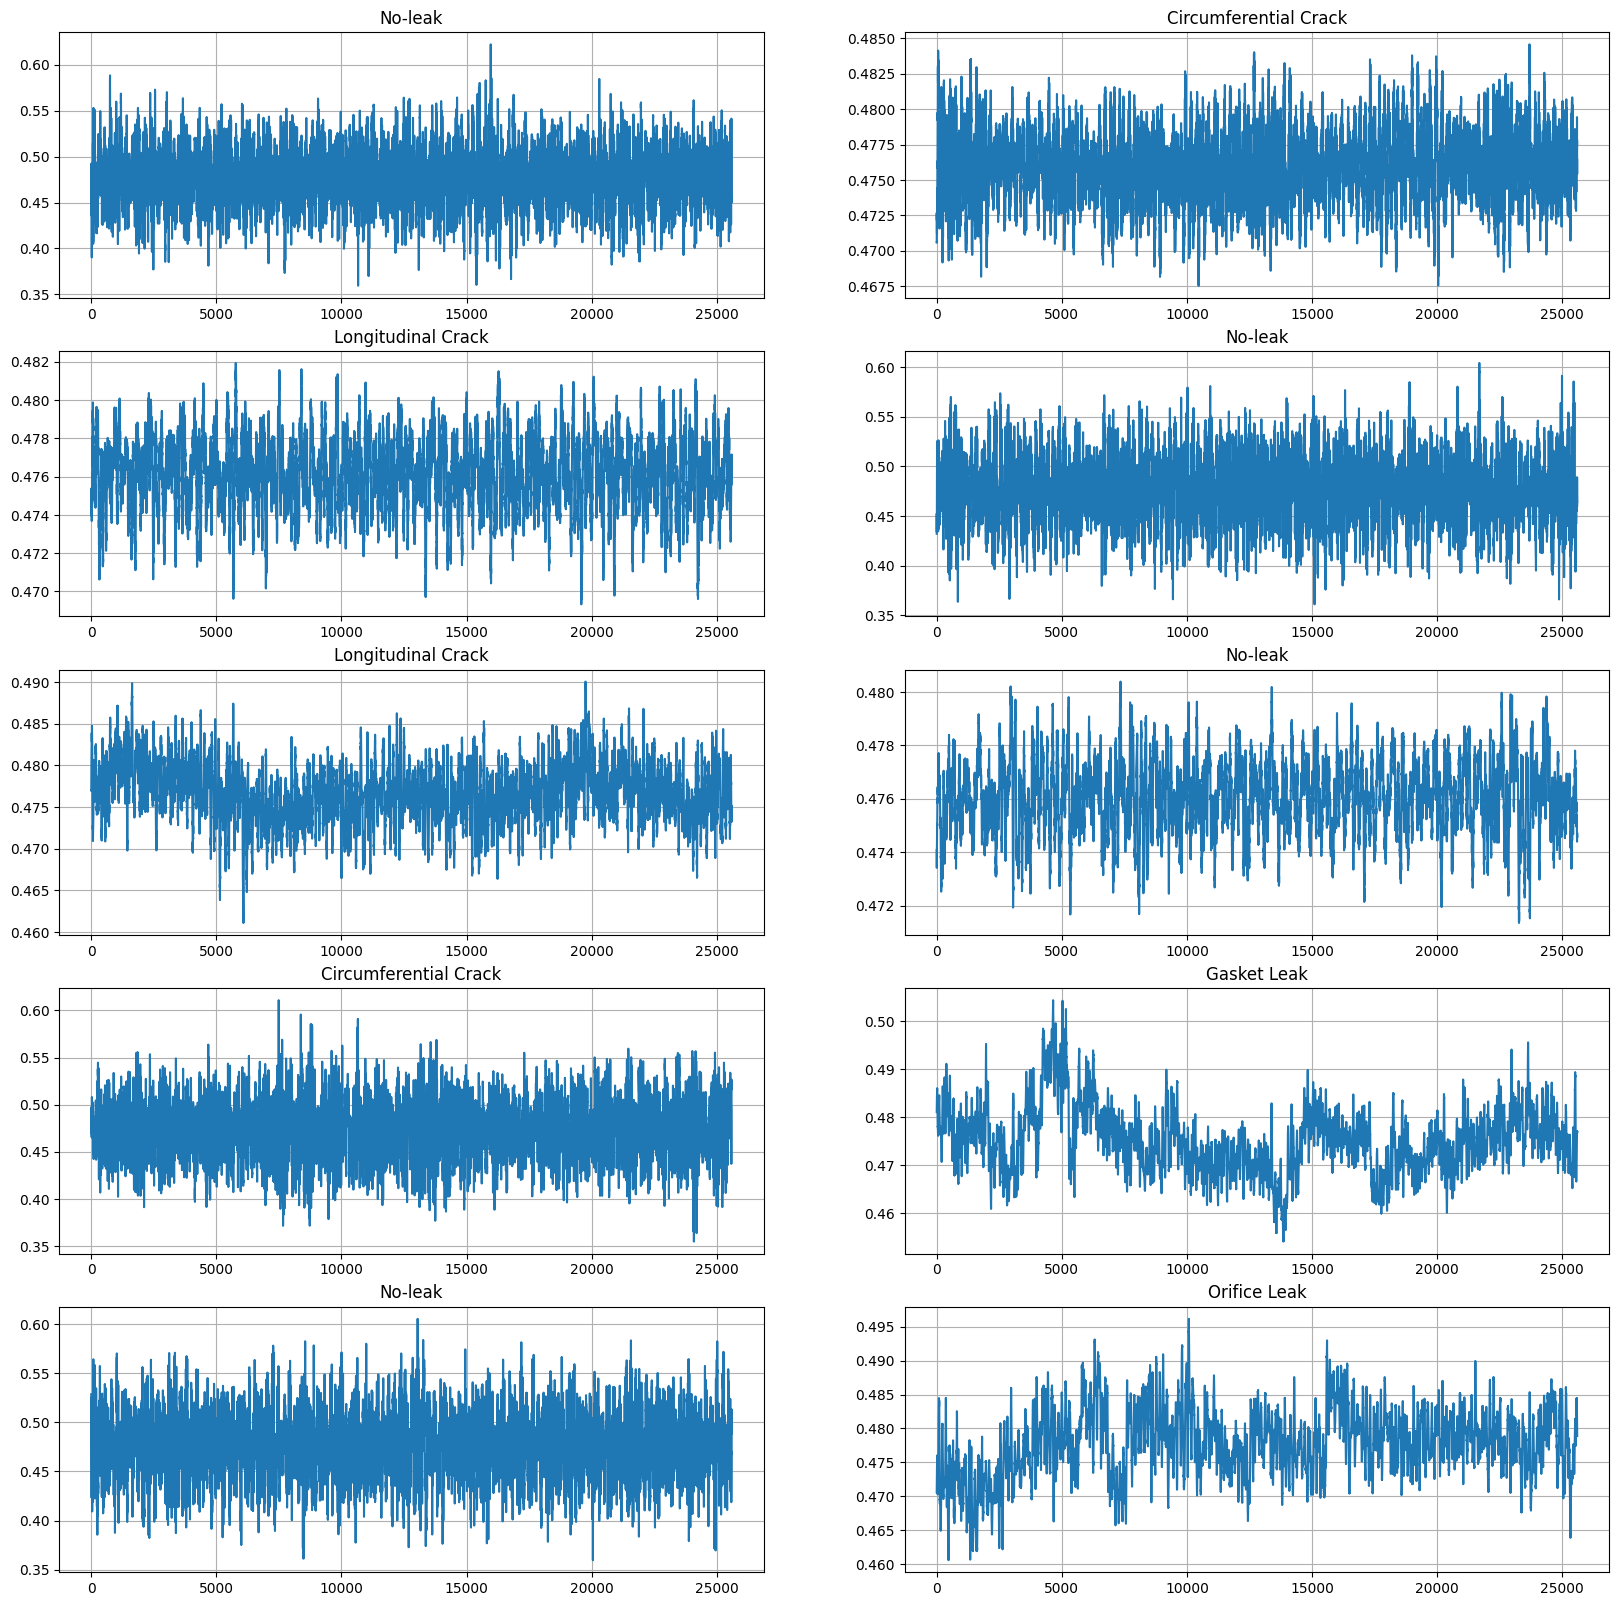

In [ ]:
# Cargar y normalizar datos brutos


# Definir la ruta de los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600 # in Hz
signal_sr = 25600 # in Hz
downsample_factor = original_sr//signal_sr

# Función para eliminar archivos .DS_Store si existen en la ruta definida
def remove_DS_store_file(path):
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, fraction_to_include=1):
    """
    Carga datos de acelerómetro sin normalizar
    """
    remove_DS_store_file(data_dir)

    raw_signals = []
    labels = []
    
    print("Cargando datos brutos...")
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue
            
        remove_DS_store_file(label_dir)
        
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            
            if not os.path.isfile(file_path):
                continue
                
            # Cargar el archivo CSV
            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :]
            accelerometer_signal_df = accelerometer_signal_df.reset_index(drop=True)
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate*30)]
            
            # Extraer segmentos de 1 segundo y almacenarlos sin normalizar
            sample_indexes = np.linspace(0, len(accelerometer_signal)-sample_rate, 
                                        len(accelerometer_signal)//sample_rate)
            signal_frames_number = fraction_to_include*len(sample_indexes)
            signal_frames_counter = 0
            
            for signal_frame in sample_indexes:
                signal_segment = accelerometer_signal[int(signal_frame):int(signal_frame+sample_rate)].values
                signal_frames_counter += 1
                
                if signal_frames_counter > signal_frames_number:
                    break
                    
                if len(signal_segment) != sample_rate:
                    continue
                    
                raw_signals.append(signal_segment)
                labels.append(label_codes[label])
    
    print(f"Señales cargadas: {len(raw_signals)}")
    
    return raw_signals, labels

# Definir el diccionario de códigos de etiquetas
label_codes_dict = {'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}

# Cargar y normalizar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(data_dir, original_sr,downsample_factor,label_codes_dict, fraction_to_include=1)

signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}
# Generate dictionaries with training and testing subsets from the loaded data
signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(signals_lst,
                                                                                                                      labels_lst,
                                                                                                                      test_size=0.2,
                                                                                                                      random_state=42,
                                                                                                                      stratify=labels_lst)

# Print information about the resulting dataset:
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][np.random.randint(0,len(signals_dict["training"]))])}')

# Plot some of the resulting signals
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols
random_index = []

for i in range(n):
  plt.subplot(rows, cols, i+1)
  random_index.append(np.random.randint(0,len(signals_dict['training'])))
  plt.plot(signals_dict['training'][random_index[i]])
  plt.title(list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])])
  plt.grid()

# Normalize the signals and perform wavelet denoising using the Discrete Wavelet Transform (DWT)

Before the feature extraction, a wavelet denoising stage is performed on the signals to remove unwanted frequency components.

Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


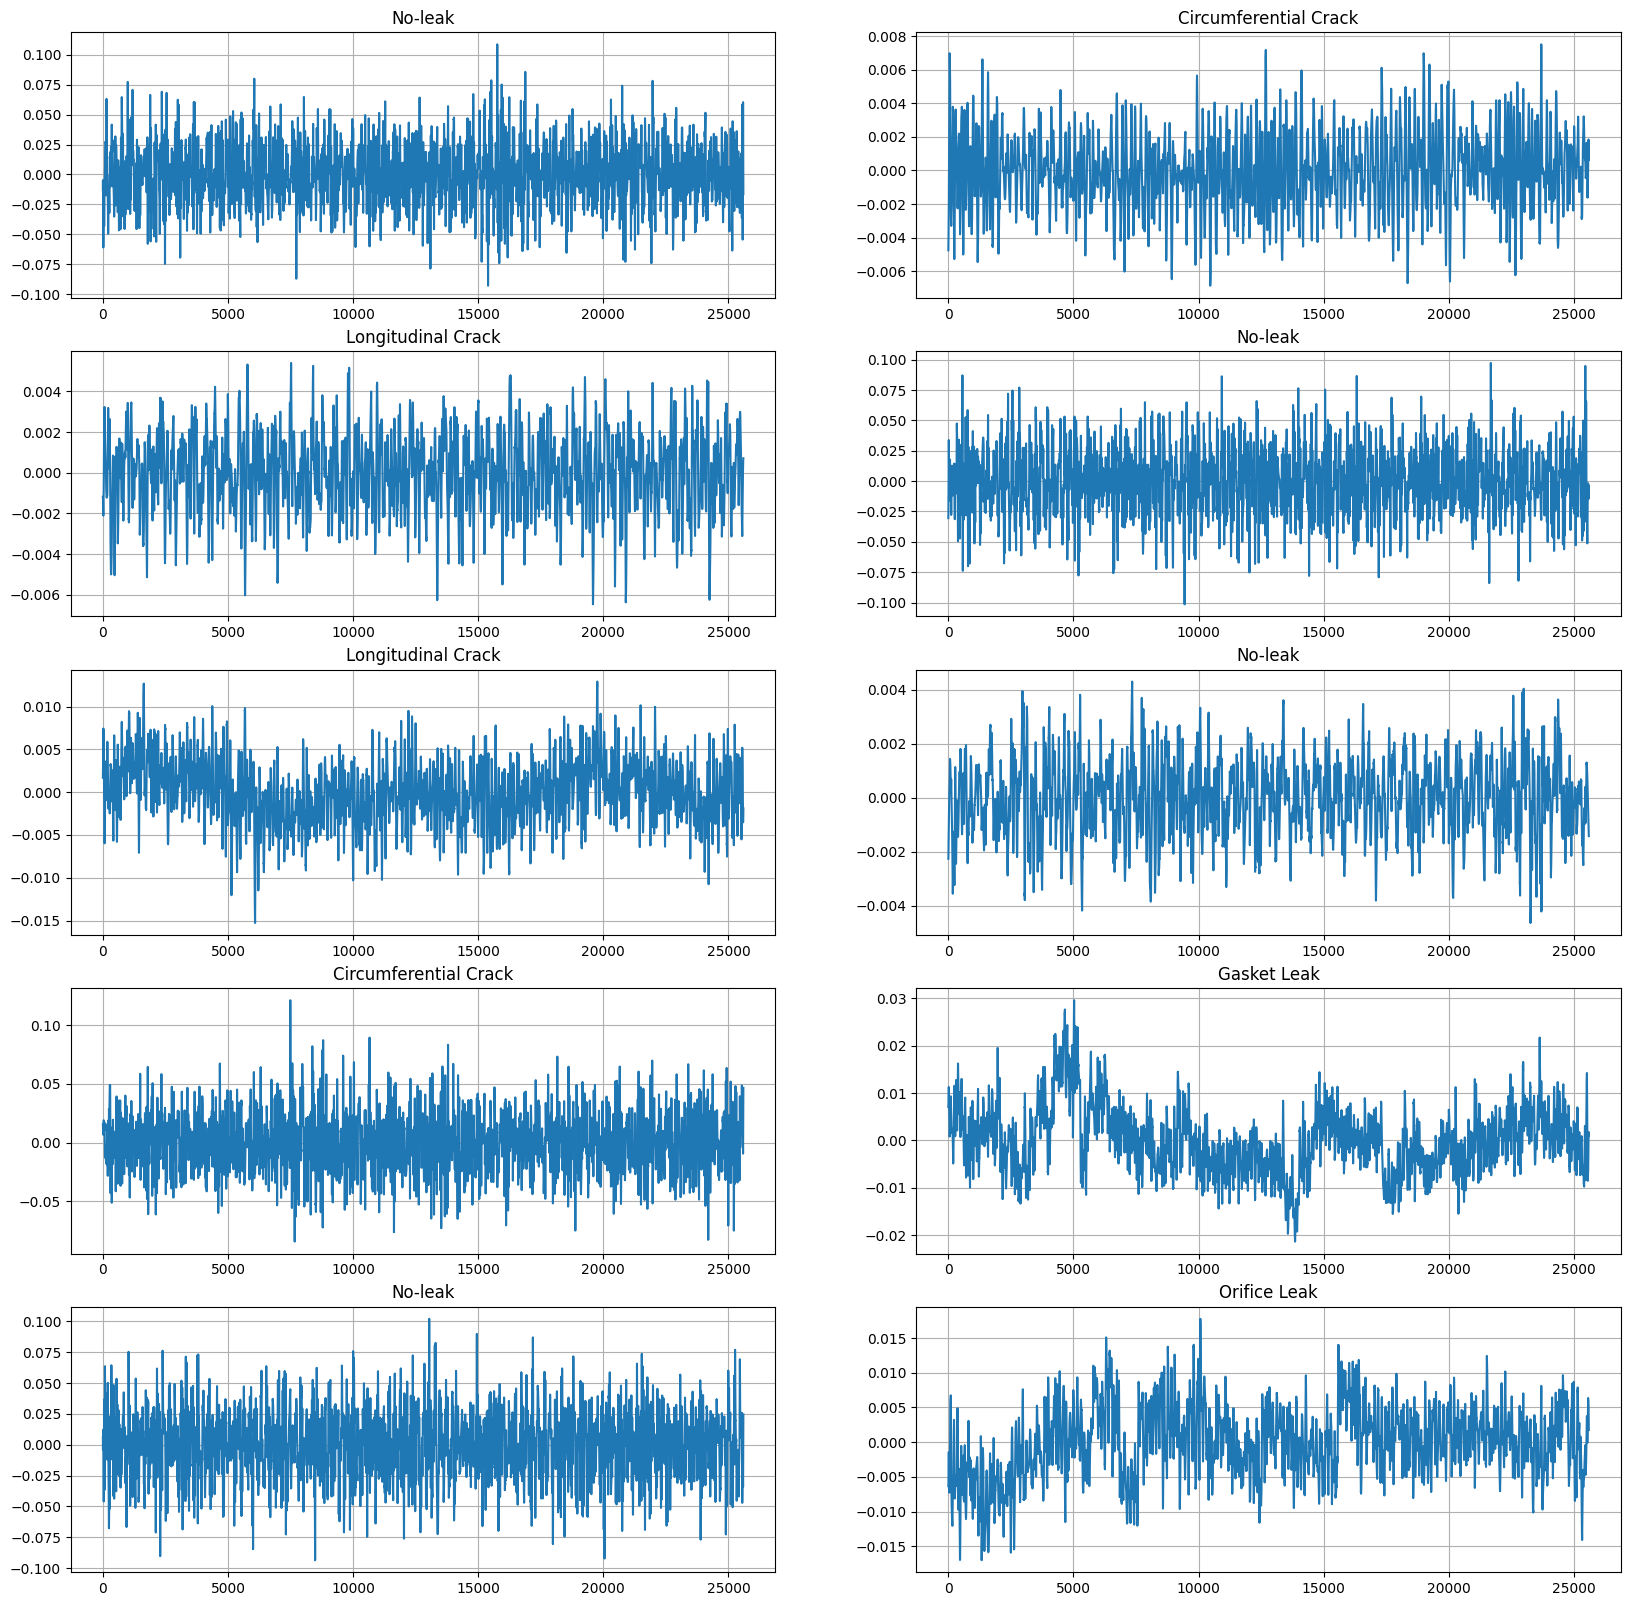

In [ ]:
def wavelet_denoise(signals_dict, labels_dict):

  # Create an object of the WaveletDenoising class
  wd = WaveletDenoising(normalize=True,
                      wavelet='sym3',
                      level=4,
                      thr_mode='soft',
                      method="universal")

  # Create a new dictionary to store the computed coefficients:
  wavelet_denoised_signals = {'training': [], 'testing': []}

  for key, signals_subset in signals_dict.items():
        for signal_element in signals_subset:

            # Denoise the signal using the wavelet denoising method
            denoised_signal = wd.fit(signal_element)

            # Store the computed scattering coeffs in the new dictionary
            wavelet_denoised_signals[key].append(denoised_signal)

  return wavelet_denoised_signals, labels_dict

# Denoise signals in the train, validation and testing dictionaries
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Print information about the resulting dataset:
print (f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print (f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print (f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][np.random.randint(0,len(wavelet_denoised_signals_dict["training"]))])}')

# Plot some of the resulting signals
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
  plt.subplot(rows, cols, i+1)
  #random_index = np.random.randint(0,len(wavelet_denoised_signals_dict['training']))
  plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])
  plt.title(list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])])
  plt.grid()

## Función para visualizar los escalogramas

In [ ]:
def plot_cwt_scalograms(scalograms, labels, label_codes_dict, num_samples, num_scales, fs=25600, num_per_class=2):
    """
    Visualiza escalogramas representativos para cada clase usando pcolormesh.
    Adaptado para diferentes tamaños de muestras.

    Args:
        scalograms: Lista de escalogramas
        labels: Lista de etiquetas correspondientes
        label_codes_dict: Diccionario que mapea códigos a nombres de etiquetas
        num_samples: Número de muestras por segmento (64, 128, 512, 1024)
        num_scales: Número de escalas del CWT (100, 50, 13, 6)
        fs: Frecuencia de muestreo
        num_per_class: Número de escalogramas a mostrar por clase
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    # Parámetros para graficar
    t_duration = num_samples / fs  # Duración del segmento en segundos

    # Obtener etiquetas únicas
    unique_labels = np.unique(labels)

    # Calcular distribución de subplots
    num_classes = len(unique_labels)
    total_plots = num_classes * num_per_class
    rows = int(np.ceil(total_plots / 3))  # Máximo 3 columnas
    cols = min(3, total_plots)

    # Crear figura
    plt.figure(figsize=(15, 4*rows))

    # Índice actual del subplot
    plot_idx = 1

    # Para cada clase de etiqueta
    for label_code in unique_labels:
        # Encontrar índices donde aparece esta etiqueta
        class_indices = [i for i, l in enumerate(labels) if l == label_code]

        # Seleccionar índices aleatorios si tenemos suficientes muestras
        import random
        if len(class_indices) >= num_per_class:
            selected_indices = random.sample(class_indices, num_per_class)
        else:
            selected_indices = class_indices

        # Graficar escalogramas seleccionados
        for idx in selected_indices:
            # Obtener escalograma
            scalogram = np.squeeze(np.array(scalograms[idx]))

            # Dimensiones del escalograma
            if len(scalogram.shape) > 2:  # Si tiene canal
                scalogram = scalogram[:,:,0]
                
            num_freqs, num_times = scalogram.shape

            # Crear ejes de tiempo y frecuencia
            t = np.linspace(0, t_duration, num_times)

            # Crear eje de frecuencia logarítmico (de mayor a menor)
            f0 = 1.0  # Frecuencia mínima
            f1 = fs/2  # Frecuencia máxima (Nyquist)
            freqs = np.geomspace(f1, f0, num_freqs)

            # Crear subplot
            ax = plt.subplot(rows, cols, plot_idx)

            # Graficar usando pcolormesh
            pcm = ax.pcolormesh(t, freqs, scalogram, shading='auto')

            # Configurar escala logarítmica para frecuencias
            ax.set_yscale('log')

            # Obtener nombre de etiqueta
            label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(label_code)]

            # Configurar títulos y etiquetas
            ax.set_title(f"{label_name}")
            ax.set_xlabel(f'Tiempo (s) - {num_samples} muestras')
            ax.set_ylabel(f'Frecuencia (Hz) - {num_scales} escalas')

            # Añadir barra de colores
            plt.colorbar(pcm, ax=ax, label='Energía')

            # Incrementar índice de subplot
            plot_idx += 1

    plt.suptitle(f"Escalogramas CWT - {num_samples} muestras x {num_scales} escalas", fontsize=16)
    plt.tight_layout()
    plt.show()

# Generar datasets con varias configuraciones de muestras/escalas
Generar y guardar múltiples datasets utilizando las configuraciones definidas: 64 muestras y 100 escalas, 128 muestras y 50 escalas, 512 muestras y 13 escalas, 1024 muestras y 6 escalas. Cada dataset debe dividirse en conjuntos de entrenamiento y prueba de manera consistente.

In [ ]:
# Crear función para generar datasets con diferentes configuraciones CWT
from fcwt.boilerplate import cwt
from tqdm import tqdm


def generate_cwt_dataset(signals_train, labels_train, signals_test, labels_test, configs):
    """
    Genera datasets de escalogramas CWT para múltiples configuraciones
    
    Args:
        signals_train: Lista de señales de entrenamiento procesadas
        labels_train: Lista de etiquetas de entrenamiento
        signals_test: Lista de señales de prueba procesadas
        labels_test: Lista de etiquetas de prueba
        configs: Lista de diccionarios con configuraciones
    
    Returns:
        datasets: Diccionario con todos los datasets generados
    """
    # Generar datasets con diferentes configuraciones
    datasets = {}

    for config in configs:
        muestras = config['muestras']
        escalas = config['escalas']
        nombre = config['nombre']
        
        print(f"\nGenerando dataset {nombre} ({muestras} muestras, {escalas} escalas)...")
        
        # Parámetros CWT
        fs = 25600  # Frecuencia de muestreo
        f0 = 1.0    # Frecuencia mínima
        f1 = fs/2   # Frecuencia máxima (Nyquist)
        fn = escalas # Número de escalas/frecuencias
        scaling="log"
        fast=True
        norm=False
        nthreads=8
        # Listas para los datasets
        x_train = []
        y_train = []
        x_test = []
        y_test = []
    # Procesar datos de entrenamiento
    for i, (signal, label) in enumerate(tqdm(zip(signals_train, labels_train), 
                                         total=len(signals_train), 
                                         desc=f"Entrenamiento {nombre}")):
     # Si la señal es más larga que las muestras necesarias, extráemos segmentos
        if len(signal) > muestras:
           num_segments = len(signal) // muestras
           for j in range(num_segments): 
             # Máximo 3 segmentos por señal para no sesgar
            segment = signal[j*muestras:(j+1)*muestras]
            
            # Calcular CWT
            freqs, fcwt_output = cwt(segment, fs, f0, f1, fn, nthreads, 
                                   scaling, fast, norm)
            
            # Calcular escalograma (magnitud al cuadrado)
            scalogram = np.square(np.abs(fcwt_output))
            
            x_train.append(scalogram)
            y_train.append(label)
        else:
        # La señal es más corta, se rellena con ceros
         segment = np.zeros(muestras)
         segment[:len(signal)] = signal
        
         # Calcular CWT
         freqs, fcwt_output = cwt(segment, fs, f0, f1, fn, nthreads=4,
                               scaling="log", fast=True, norm=False)
        
         # Calcular escalograma
         scalogram = np.square(np.abs(fcwt_output))
        
         x_train.append(scalogram)
         y_train.append(label)
        
     # Procesar datos de prueba
    for i, (signal, label) in enumerate(tqdm(zip(signals_test, labels_test), 
                                                 total=len(signals_test), 
                                                 desc=f"Prueba {nombre}")):
        # Igual que el proceso anterior
        if len(signal) > muestras:
            num_segments = len(signal) // muestras
            for j in range(num_segments):
                segment = signal[j*muestras:(j+1)*muestras]
                freqs, fcwt_output = cwt(segment, fs, f0, f1, fn, nthreads=4,
                                           scaling="log", fast=True, norm=False)
                scalogram = np.square(np.abs(fcwt_output))
                x_test.append(scalogram)
                y_test.append(label)
        else:
            segment = np.zeros(muestras)
            segment[:len(signal)] = signal
            freqs, fcwt_output = cwt(segment, fs, f0, f1, fn, nthreads=4,
                                       scaling="log", fast=True, norm=False)
            scalogram = np.square(np.abs(fcwt_output))
            x_test.append(scalogram)
            y_test.append(label)
        
     # Convertir a arrays numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
        # Normalizar los escalogramas
    max_val = np.max(x_train)
    x_train = x_train / max_val
    x_test = x_test / max_val
        
        # Expandir dimensión para canal (necesario para CNN)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
        
        # One-hot encoding de las etiquetas
    num_classes = len(np.unique(labels_train + labels_test))
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

        # Visualizar ejemplos usando la función plot_cwt_scalograms
    print("\nVisualizando ejemplos de escalogramas...")
    # Guardar la figura antes de mostrarla
    plt.figure()
    plot_cwt_scalograms(
        x_train,                # escalogramas
        y_train,                # etiquetas (raw, no one-hot)
        label_codes_dict,       # diccionario de etiquetas
        config["muestras"],     # número de muestras
        config["escalas"],      # número de escalas
        fs=25600,               # frecuencia de muestreo
        num_per_class=1         # número de ejemplos por clase (1 por clase para no saturar)
    )
    plt.savefig(f"/content/drive/MyDrive/ejemplos_{nombre}.png")
        
        # Guardar en el diccionario de datasets
    datasets[nombre] = {
            'x_train': x_train,
            'y_train': y_train_onehot,
            'x_test': x_test,
            'y_test': y_test_onehot,
            'y_train_raw': y_train,
            'y_test_raw': y_test,
            'config': config
        }
        
    print(f"Dataset {nombre} generado:")
    print(f"- x_train: {x_train.shape}")
    print(f"- y_train: {y_train_onehot.shape}")
    print(f"- x_test: {x_test.shape}")
    print(f"- y_test: {y_test_onehot.shape}")
    
    return datasets

all_datasets = generate_cwt_dataset(wavelet_denoised_signals_dict['training'],
                                    labels_dict['training'],
                                    wavelet_denoised_signals_dict['testing'],
                                    labels_dict['testing'],
                                    configs)


# Entrenamiento de modelos CNN para cada configuración
Crear y entrenar un modelo CNN básico para cada configuración de dataset. Utilizar la misma arquitectura para todos los experimentos para garantizar una comparación justa. Registrar métricas importantes como precisión, pérdida y tiempo de entrenamiento.

In [ ]:
def create_and_train_cnn(dataset, label_codes_dict):
    """
    Crea y entrena un modelo CNN básico para un dataset específico
    
    Args:
        dataset: Diccionario con datos de entrenamiento y prueba
        label_codes_dict: Diccionario de etiquetas
    
    Returns:
        history: Historial de entrenamiento
        model: Modelo entrenado
        evaluation: Resultados de evaluación
    """
    # Obtener datos
    x_train = dataset['x_train']
    y_train = dataset['y_train']
    x_test = dataset['x_test']
    y_test = dataset['y_test']
    config = dataset['config']
    
    # Dividir datos de entrenamiento para validación
    x_train_final, x_val, y_train_final, y_val = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )
    
    # Número de clases
    num_classes = len(label_codes_dict)
    
    # Forma de entrada
    input_shape = x_train.shape[1:]
    
    # Crear modelo CNN básico
    def create_tiny_cnn_model(input_shape, num_classes):
        model = keras.Sequential([
            # Capa de entrada
            tf.keras.layers.Input(shape=input_shape),
            
            # Bloque 1: 8 filtros
            tf.keras.layers.Conv2D(8, kernel_size=(3, 3), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Bloque 2: 16 filtros
            tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Bloque 3: 32 filtros
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Capa de salida
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model
    
    # Crear modelo
    model = create_tiny_cnn_model(input_shape, num_classes)
    model.summary()
    
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(f'/content/drive/MyDrive/best_model_{config["nombre"]}.h5', 
                        save_best_only=True, monitor='val_accuracy')
    ]
    
    # Entrenar modelo
    history = model.fit(
        x_train_final, y_train_final,
        batch_size=32,
        epochs=100,
        validation_data=(x_val, y_val),
        callbacks=callbacks
    )
    
    # Evaluar modelo
    evaluation = model.evaluate(x_test, y_test)
    
    # Visualizar resultados
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/training_{config['nombre']}.png")
    plt.show()
    
    # Matriz de confusión
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {config["nombre"]}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.savefig(f"/content/drive/MyDrive/confusion_{config['nombre']}.png")
    plt.show()
    
    print(classification_report(y_true, y_pred))
    
    return history, model, evaluation

# Entrenar modelos para cada configuración

In [ ]:
# Entrenar y evaluar modelos para cada configuración
results = {}
for name, dataset in all_datasets.items():
    print(f"\n\n===== Entrenando modelo para configuración: {name} =====")
    history, model, evaluation = create_and_train_cnn(dataset, label_codes_dict)
    
    results[name] = {
        'history': history.history,
        'test_loss': evaluation[0],
        'test_accuracy': evaluation[1],
        'model': model
    }
    
    print(f"Resultados para {name}:")
    print(f"- Pérdida en test: {evaluation[0]:.4f}")
    print(f"- Precisión en test: {evaluation[1]:.4f}")

# Guardar resultados en un archivo
import pickle
with open('/content/drive/MyDrive/resultados_configuraciones.pkl', 'wb') as f:
    pickle.dump({k: {
        'history': v['history'], 
        'test_loss': v['test_loss'], 
        'test_accuracy': v['test_accuracy']
    } for k, v in results.items()}, f)

# Comparar resultados entre configuraciones

In [ ]:
# Comparar precisión entre configuraciones
accuracies = []
losses = []
configs_names = []

for name, result in results.items():
    accuracies.append(result['test_accuracy'])
    losses.append(result['test_loss'])
    configs_names.append(name)

# Crear gráficos comparativos
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(configs_names, accuracies, color='skyblue')
plt.title('Precisión en Test por Configuración')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')

plt.subplot(1, 2, 2)
plt.bar(configs_names, losses, color='salmon')
plt.title('Pérdida en Test por Configuración')
for i, loss in enumerate(losses):
    plt.text(i, loss + 0.02, f'{loss:.4f}', ha='center')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/comparacion_configuraciones.png')
plt.show()

# Encontrar la mejor configuración
best_idx = np.argmax(accuracies)
best_config = configs_names[best_idx]
print(f"La mejor configuración es: {best_config} con una precisión de {accuracies[best_idx]:.4f}")

# Exportación del mejor modelo para STM32
Exportar el modelo con mejor rendimiento a formato TFLite para su uso en STM32. Aplicar optimizaciones adicionales como cuantización para reducir aún más el tamaño del modelo y mejorar la eficiencia en el microcontrolador.

In [ ]:
# Exportar el mejor modelo a formato TFLite para microcontrolador

# Obtener el mejor modelo
best_model = results[best_config]['model']

# Convertir a TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Guardar el modelo TFLite
with open(f'/content/drive/MyDrive/mejor_modelo_{best_config}.tflite', 'wb') as f:
    f.write(tflite_model)

# Guardar también el modelo original en formato HDF5
best_model.save(f'/content/drive/MyDrive/mejor_modelo_{best_config}.h5')

print(f"Modelo convertido y guardado como 'mejor_modelo_{best_config}.tflite'")
print(f"Tamaño del modelo: {len(tflite_model) / 1024:.2f} KB")

# Ver detalles adicionales del modelo
print("\nDetalles del modelo:")
print(f"- Entrada: {best_model.input.shape}")
print(f"- Salida: {best_model.output.shape}")
print(f"- Número de parámetros: {best_model.count_params()}")

# Preparar datasets en formato H5 para uso posterior

In [ ]:
# Guardar también los datasets de la mejor configuración en formato H5
best_dataset = all_datasets[best_config]

# Estructura para guardar el dataset
output_file = f'/content/drive/MyDrive/accelerometer_{best_config}_cwt_dataset.h5'

with h5py.File(output_file, 'w') as hf:
    # Crear grupos
    train_group = hf.create_group('train')
    test_group = hf.create_group('test')
    metadata_group = hf.create_group('metadata')
    
    # Guardar datos de entrenamiento
    train_group.create_dataset('scalograms', data=best_dataset['x_train'])
    train_group.create_dataset('labels', data=best_dataset['y_train_raw'])
    
    # Guardar datos de prueba
    test_group.create_dataset('scalograms', data=best_dataset['x_test'])
    test_group.create_dataset('labels', data=best_dataset['y_test_raw'])
    
    # Guardar metadatos
    metadata_group.create_dataset('num_classes', data=len(label_codes_dict))
    metadata_group.create_dataset('shape', data=best_dataset['x_train'].shape[1:])
    
    # Guardar diccionario de etiquetas como atributo
    metadata_group.attrs['label_codes_dict'] = json.dumps(label_codes_dict)

print(f"Dataset de la mejor configuración guardado como '{output_file}'")

# Conclusiones y resultados finales

In [ ]:
print("\n====== RESUMEN DE RESULTADOS ======")
print(f"Mejor configuración: {best_config}")
print(f"Precisión en prueba: {accuracies[best_idx]:.4f}")
print(f"Pérdida en prueba: {losses[best_idx]:.4f}")

print("\nResumen de todas las configuraciones probadas:")
for i, name in enumerate(configs_names):
    cfg = configs[i]
    print(f"- {name} ({cfg['muestras']} muestras x {cfg['escalas']} escalas): Precisión={accuracies[i]:.4f}, Pérdida={losses[i]:.4f}")

# Análisis de ventajas de la mejor configuración para STM32
print("\nVentajas de la mejor configuración para STM32:")
best_idx_config = configs_names.index(best_config)
best_cfg = configs[best_idx_config]

# Calcular memoria aproximada requerida para el modelo
model_size_kb = len(tflite_model) / 1024
input_size = np.prod(best_model.input.shape[1:])
print(f"- Tamaño del modelo: {model_size_kb:.2f} KB")
print(f"- Memoria requerida para entrada: {input_size * 4 / 1024:.2f} KB (float32)")
print(f"- Relación precisión/memoria: {accuracies[best_idx] / model_size_kb:.6f} por KB")

# Conclusiones finales
print("\nCONCLUSIONES:")
print(f"""
1. La configuración {best_config} ({best_cfg['muestras']} muestras x {best_cfg['escalas']} escalas) 
   logró la mejor precisión de clasificación ({accuracies[best_idx]:.4f}).
   
2. Esta configuración ofrece un buen balance entre precisión de clasificación y 
   requerimientos computacionales para un microcontrolador STM32.
   
3. La normalización de los datos antes del procesamiento y el denoising de wavelet 
   contribuyeron significativamente a la calidad de los escalogramas generados.
   
4. El modelo entrenado es suficientemente compacto para ser implementado en un 
   microcontrolador STM32 con memoria limitada.
""")